In [1]:
pip install tiktoken

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

# Example: Loading the IMDB dataset
data = load_dataset("lavita/medical-qa-datasets", 'all-processed')
data = data['train'].train_test_split(test_size=0.2)

In [3]:
train_data = data['train']
val_data = data['test']

In [4]:
print("Number of entries:", len(train_data))
print("Example entry:\n", train_data[50])

Number of entries: 191485
Example entry:
 {'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'Woman, 38 yrs old, 84 kg. 8 months with right upper quadrant pain, negative Murphy s sign, positive right fist percussion, klebsiella pneumoniae in developing urinalysis ( 100,000 U / ml), 3 cm cyst in right ovary, abdominal and thoracic radiographs normal, hepatomegaly , NSAIDs paracetamol codeine, diarrhea, metrorrhagia , menorrhagia, acalculous gallbladder, loss of 12 kg in the first two weeks, worsens with activity', 'output': 'hi and welcome to chatbot, thank you for your query. you need more detailed gastroenterology work up to evaluate the cause of your liver problem which is the biggest worry about you at this point. you should check your viral marker and do liver biopsy if necessary. it can be also gallbladder issue or pancreatic disease, so you should do at least ct scan and certain blood tests to rule these out. y

In [5]:
print("Another example entry:\n", train_data[999])

Another example entry:
 {'instruction': 'Please summerize the given abstract to a title', 'input': 'The emergence of the COVID-19 outbreak at the end of 2019, caused by the novel coronavirus SARS-CoV-2, has, to date, led to over 13.6 million infections and nearly 600,000 deaths. Consequently, there is an urgent need to better understand the molecular factors triggering immune defense against the virus and to develop countermeasures to hinder its spread. Using in silico analyses, we showed that human major histocompatibility complex (MHC) class I cell-surface molecules vary in their capacity for binding different SARS-CoV-2-derived epitopes, i.e., short sequences of 8-11 amino acids, and pinpointed five specific SARS-CoV-2 epitopes that are likely to be presented to cytotoxic T-cells and hence activate immune responses. The identified epitopes, each one of nine amino acids, have high sequence similarity to the equivalent epitopes of SARS-CoV virus, which are known to elicit an effective

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
model_input = format_input(train_data[50])
desired_response = f"\n\n### Response:\n{train_data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
If you are a doctor, please answer the medical questions based on the patient's description.

### Input:
Woman, 38 yrs old, 84 kg. 8 months with right upper quadrant pain, negative Murphy s sign, positive right fist percussion, klebsiella pneumoniae in developing urinalysis ( 100,000 U / ml), 3 cm cyst in right ovary, abdominal and thoracic radiographs normal, hepatomegaly , NSAIDs paracetamol codeine, diarrhea, metrorrhagia , menorrhagia, acalculous gallbladder, loss of 12 kg in the first two weeks, worsens with activity

### Response:
hi and welcome to chatbot, thank you for your query. you need more detailed gastroenterology work up to evaluate the cause of your liver problem which is the biggest worry about you at this point. you should check your viral marker and do liver biopsy if necessary. it can be also gallbladder issue or pancreatic disease, so you shou

In [8]:
model_input = format_input(train_data[999])
desired_response = f"\n\n### Response:\n{train_data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Please summerize the given abstract to a title

### Input:
The emergence of the COVID-19 outbreak at the end of 2019, caused by the novel coronavirus SARS-CoV-2, has, to date, led to over 13.6 million infections and nearly 600,000 deaths. Consequently, there is an urgent need to better understand the molecular factors triggering immune defense against the virus and to develop countermeasures to hinder its spread. Using in silico analyses, we showed that human major histocompatibility complex (MHC) class I cell-surface molecules vary in their capacity for binding different SARS-CoV-2-derived epitopes, i.e., short sequences of 8-11 amino acids, and pinpointed five specific SARS-CoV-2 epitopes that are likely to be presented to cytotoxic T-cells and hence activate immune responses. The identified epitopes, each one of nine amino acids, have high sequence similarity t

In [9]:
print("Training set length:", train_data.shape)
print("Validation set length:", val_data.shape)

Training set length: (191485, 4)
Validation set length: (47872, 4)


In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [14]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [15]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 4

# torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [16]:
!cp /kaggle/input/data-gpt-lat/gpt_download.py /kaggle/working/gpt_download.py
!cp /kaggle/input/data-gpt-lat/utils.py /kaggle/working/utils.py

In [17]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt


# BASE_CONFIG = {
#     "vocab_size": 50257,     # Vocabulary size
#     "context_length": 1024,  # Context length
#     "drop_rate": 0.0,        # Dropout rate
#     "qkv_bias": True         # Query-key-value bias
# }

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# CHOOSE_MODEL = "gpt2-large (774M)"
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [18]:
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Please answer the letter of option truthfully

### Input:
Q:A 52-year-old female presents to the office with the complaint of greenish discharge from her left nipple. There is no history of trauma or fever, and the patient is not currently using oral contraceptives nor is she on hormone replacement therapy. Her last pregnancy was approximately 20 years ago. Physical examination findings are normal except for the green discharge. The most likely cause of this patient's presenting complaint is? 
A:breast cancer;B:fibrocystic disease;C:mammary duct ectasia;D:pituitary adenoma


In [19]:
from utils import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [20]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

;E:posterior ovarian cancer;F:posterior uterine carcinoma;G:posterior uterine carcinoma;H:posterior uter


In [21]:
from utils import (
    calc_loss_loader,
    train_model_simple
)

In [22]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.73687105178833
Validation loss: 3.7888275146484376


In [23]:
import time

start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=1000, eval_iter=1000,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.494, Val loss 3.513
Ep 1 (Step 001000): Train loss 2.492, Val loss 2.496
Ep 1 (Step 002000): Train loss 2.446, Val loss 2.434
Ep 1 (Step 003000): Train loss 2.389, Val loss 2.400
Ep 1 (Step 004000): Train loss 2.369, Val loss 2.374
Ep 1 (Step 005000): Train loss 2.336, Val loss 2.349
Ep 1 (Step 006000): Train loss 2.296, Val loss 2.338
Ep 1 (Step 007000): Train loss 2.286, Val loss 2.321
Ep 1 (Step 008000): Train loss 2.269, Val loss 2.308
Ep 1 (Step 009000): Train loss 2.257, Val loss 2.297
Ep 1 (Step 010000): Train loss 2.245, Val loss 2.285
Ep 1 (Step 011000): Train loss 2.241, Val loss 2.276
Ep 1 (Step 012000): Train loss 2.224, Val loss 2.266
Ep 1 (Step 013000): Train loss 2.231, Val loss 2.261
Ep 1 (Step 014000): Train loss 2.203, Val loss 2.251
Ep 1 (Step 015000): Train loss 2.194, Val loss 2.246
Ep 1 (Step 016000): Train loss 2.182, Val loss 2.245
Ep 1 (Step 017000): Train loss 2.211, Val loss 2.234
Ep 1 (Step 018000): Train loss 2.164, Val loss

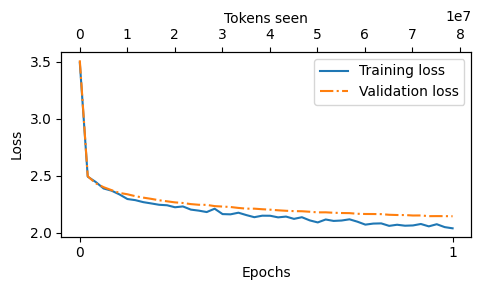

In [24]:
from utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [37]:
for i in range(8, 16):

    input_text = format_input(val_data[i])

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {val_data[i]['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Answer this question truthfully

### Input:
In cases of yellow fever, which zone of the liver is typically affected?

Correct response:
>> Yellow fever typically affects Zone II, also known as the intermediate zone, of the liver. This zone is located between Zone I and Zone III and is responsible for the production of bile acids, which help with digestion and the removal of waste from the body. The virus that causes yellow fever specifically targets and damages liver cells in this zone, leading to symptoms such as jaundice, abdominal pain, and liver enlargement. In severe cases, yellow fever can progress to a more serious form of the disease, which can cause bleeding, shock, and organ failure. Treatment for yellow fever typically involves supportive care, such as hydration and pain management, as there is currently no specific antiviral treatment available. Vaccin

In [ ]:
file_name = "lavita-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")